In [ ]:
import os
import pkg_resources
import numpy as np
import json

from convokit import Corpus, QuestionTypology, download, MotifsExtractor, QuestionTypologyUtils

import itertools
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from ast import literal_eval as make_tuple
from collections import defaultdict
from scipy import sparse
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import Normalizer
from spacy.en import English
from spacy.symbols import *
from spacy.tokens.doc import Doc


In [ ]:
#Initialize QuestionTypology class pretrained on Parliament Dataset

num_clusters = 8

data_dir = download('parliament-corpus')
motifs_dir = download('parliament-motifs')

corpus = Corpus(filename=os.path.join(data_dir, 'parliament-corpus'))

questionTypology = QuestionTypology(corpus, data_dir, dataset_name='parliament', motifs_dir=motifs_dir, num_dims=25,
  num_clusters=num_clusters, verbose=False, random_seed=164)

In [3]:
# def display_question_type_log_odds_graph():
# '''
#     Recreates figure 1a from the paper. labels are the labels
#     that should be printed alongside each pair of data points.
#     order_of_display is the order in which these labels correspond to the
#     clusters, and the order they should be displayed
# '''
pair_delim = '-q-a-'

order_of_display = [4,7,0,5,2,6,3,1]
clusters = [i for i in order_of_display[::-1]]

num_questions_govt = [0 for i in order_of_display]
num_questions_opp = [0 for i in order_of_display]
num_questions_untyped = 0

j = 0
num_omissions_for_lack_of_user_info = 0
num_omissions_for_shadow_ministers = 0
num_omissions_for_govt_ministers = 0
num_included_questions = 0
text_iter = questionTypology.corpus.iterate_by('questions', MotifsExtractor.does_utterance_have_only_one_question)
for (_, (_,_,pair_idx)) in enumerate(text_iter):
    j += 1
    if questionTypology.verbose and j%questionTypology.verbose == 0:
        print(j)
    utterance = questionTypology.corpus.utterances[pair_idx[:pair_idx.find(pair_delim)]]
    num_questions_in_utterance = utterance.text.count('?')
    user_info = utterance.other['user-info']
    if "is_minister" not in user_info:
        num_omissions_for_lack_of_user_info += 1
        continue
    if (user_info["is_oppn"] and user_info["is_minister"]):
        num_omissions_for_shadow_ministers += 1
        continue
    if (not user_info["is_oppn"] and user_info["is_minister"]):
        num_omissions_for_govt_ministers += 1
        continue
    num_included_questions += 1
    for i in order_of_display:
        if pair_idx in questionTypology.types_to_data[i]["questions"]:
            if user_info["is_oppn"]:
                num_questions_opp[i] += 1
            elif not user_info["is_oppn"]:
                num_questions_govt[i] += 1
            else:
                num_questions_untyped += 1

In [4]:
print (len(questionTypology.corpus.utterances.values())/2, ' total utterance pairs')
print(j, ' total utterances with just one question')
print(num_included_questions, ' included')
print(num_omissions_for_lack_of_user_info, ' omissions for lack of user info')
print(num_omissions_for_shadow_ministers, ' omissions for shadow ministers')
print(num_omissions_for_govt_ministers, ' omissions for govt ministers')
print('govt question distribution: ', num_questions_govt, 'total: ', sum(num_questions_govt))
print('opp question distribution: ', num_questions_opp, 'total: ', sum(num_questions_opp))
print('untyped questions: ', num_included_questions - sum(num_questions_opp) - sum(num_questions_govt))

216894.0  total utterance pairs
103735  total utterances with just one question
40879  included
0  omissions for lack of user info
16629  omissions for shadow ministers
46227  omissions for govt ministers
govt question distribution:  [2521, 2828, 2123, 5691, 4030, 5125, 3439, 2362] total:  28119
opp question distribution:  [2019, 1092, 1489, 1421, 1992, 1890, 1254, 758] total:  11915
untyped questions:  845


In [5]:
total_questions_of_each_type = [num_questions_govt[i] + num_questions_opp[i] for i in range(questionTypology.num_clusters)]
govt_log_odds = []
opp_log_odds = []
for i in range(questionTypology.num_clusters):
    p = num_questions_govt[i]/total_questions_of_each_type[i]
    govt_log_odds_value = np.log(p/(1-p)) 
    govt_log_odds.append(govt_log_odds_value)
    opp_log_odds.append(-govt_log_odds_value)
# govt_log_odds = [np.log(num_questions_govt[i]/len(questionTypology.types_to_data[i]["questions"])) -
#     np.log((len(questionTypology.types_to_data[i]["questions"]) - num_questions_govt[i])/len(questionTypology.types_to_data[i]["questions"]))
#     for i in range(questionTypology.num_clusters)]
# opp_log_odds = [np.log(num_questions_opp[i]/len(questionTypology.types_to_data[i]["questions"])) -
#     np.log((len(questionTypology.types_to_data[i]["questions"]) - num_questions_opp[i])/len(questionTypology.types_to_data[i]["questions"]))
#     for i in range(questionTypology.num_clusters)]

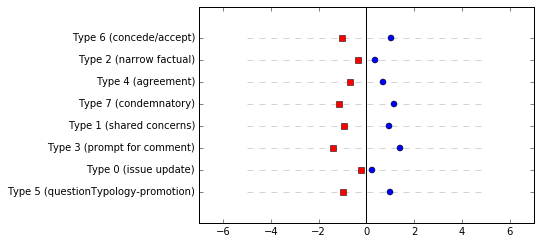

In [6]:
govt_data_style = 'bo'
opp_data_style = 'rs'

line_x = np.linspace(-5, 5, questionTypology.num_clusters) #for lines

labels = ['Type 0 (issue update)', #Here Type 4
        'Type 1 (shared concerns)', #Here Type 7
        'Type 2 (narrow factual)', #Here Type 0
        'Type 3 (prompt for comment)', #Here Type 5
        'Type 4 (agreement)', #Here Type 2
        'Type 5 (questionTypology-promotion)', #Here Type 6
        'Type 6 (concede/accept)', #Here Type 3
        'Type 7 (condemnatory)'] #Here Type 1


#plot lines - probably a better way of doing this
for i in clusters:
    y_i = np.full(questionTypology.num_clusters,i)
    plt.plot(line_x, y_i, linestyle='dashed', linewidth=1, color='lightgrey')

#plot govt
govt_plot, = plt.plot(govt_log_odds, clusters, govt_data_style, label='government affiliated')

#plot opposition
opp_plot, = plt.plot(opp_log_odds, clusters, opp_data_style, label='opposition affiliated')

#legend
# plt.legend(handles=[govt_plot, opp_plot], loc='lower right')

#add labels
plt.yticks(clusters, labels, rotation='horizontal')

#add central line
plt.axvline(x=0, color='black')

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)

plt.show() #This can be changed to show or write to file

In [ ]:
questionTypology.display_totals()
print('10 examples for types 1-8:')
for i in range(num_clusters):
    questionTypology.display_motifs_for_type(i, num_egs=10)
    questionTypology.display_answer_fragments_for_type(i, num_egs=10)
    questionTypology.display_question_answer_pairs_for_type(i, num_egs=10)